Loading audio file: data/epi.wav
Audio duration: 20.00 seconds
Extracting pitch features...
Extracting energy features...
Extracting rhythm features...
Extracting spectral features...
Detecting speech emphasis...
Features saved to prosodic_features.csv

Key Prosodic Features:
Pitch Mean: 117.30 Hz
Pitch Range: 230.67 Hz
Energy Variability: 68.72%
Speech Rate: 24.00 segments/minute
Emphasis Rate: 0.40 emphases/second


/var/folders/p1/y751_lzn243fr_s_xsbxvhgw0000gn/T/ipykernel_21333/706319913.py:275: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


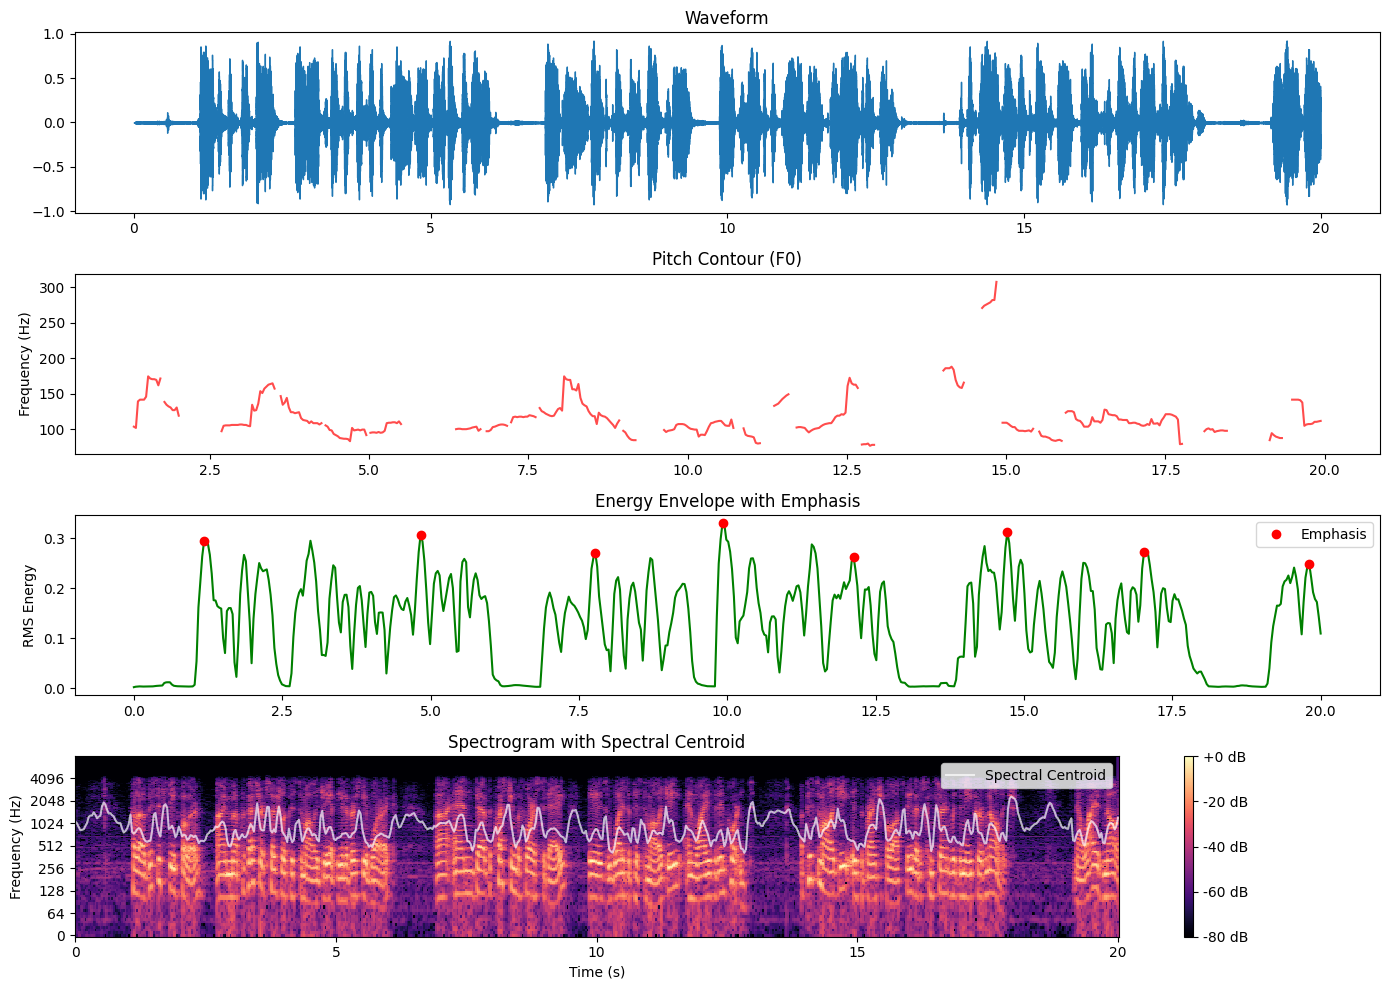

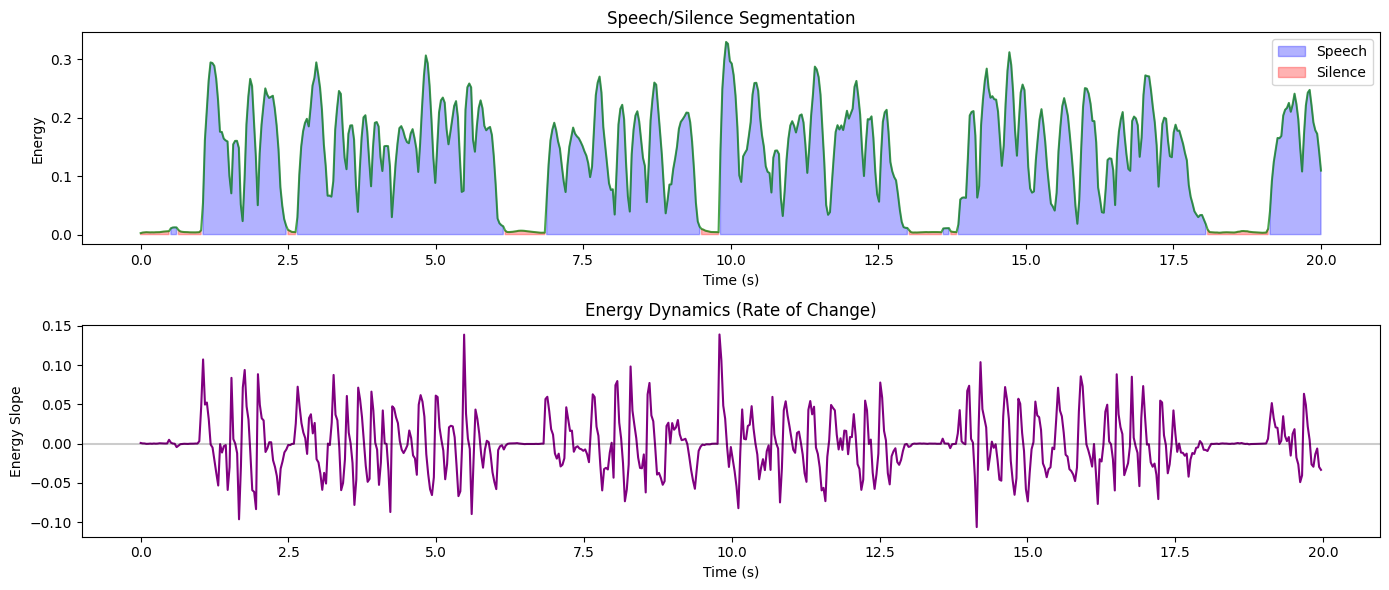


Emotion Analysis (simplified demonstration):
Excitement: 0.56
Intensity: 0.74
Calmness: 0.40

Comparing with audioguide file...
Loading audio file: data/speech-and-music.wav
Audio duration: 14.20 seconds
Extracting pitch features...
Extracting energy features...
Extracting rhythm features...
Extracting spectral features...
Detecting speech emphasis...


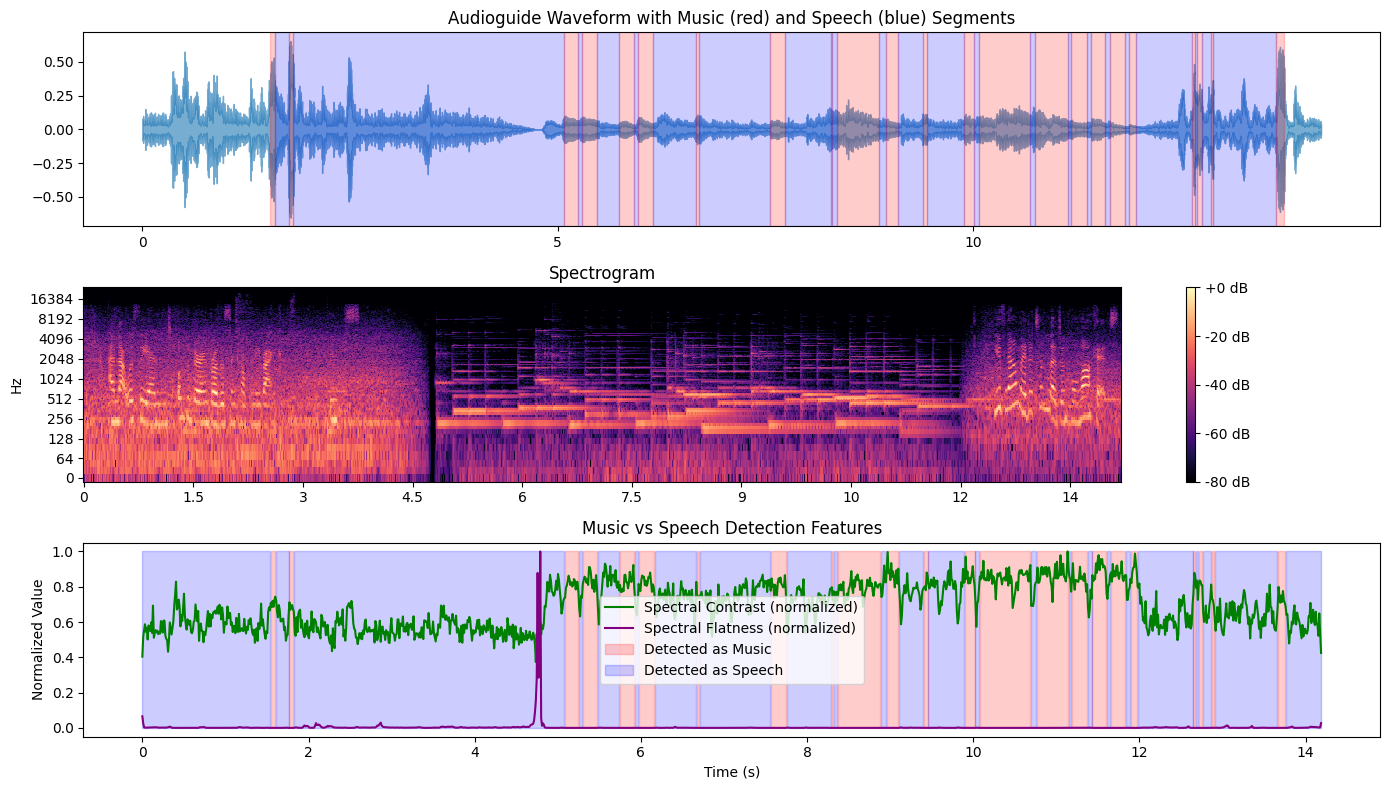


Audioguide Segmentation:
Music segment: 1.54s - 1.60s (duration: 0.06s)
Speech segment: 1.60s - 1.76s (duration: 0.16s)
Music segment: 1.76s - 1.81s (duration: 0.05s)
Speech segment: 1.81s - 5.08s (duration: 3.26s)
Music segment: 5.08s - 5.25s (duration: 0.17s)
Speech segment: 5.25s - 5.29s (duration: 0.04s)
Music segment: 5.29s - 5.47s (duration: 0.18s)
Speech segment: 5.47s - 5.74s (duration: 0.27s)
Music segment: 5.74s - 5.92s (duration: 0.18s)
Speech segment: 5.92s - 5.96s (duration: 0.04s)
Music segment: 5.96s - 6.15s (duration: 0.19s)
Speech segment: 6.15s - 6.67s (duration: 0.51s)
Music segment: 6.67s - 6.70s (duration: 0.03s)
Speech segment: 6.70s - 7.55s (duration: 0.85s)
Music segment: 7.55s - 7.74s (duration: 0.19s)
Speech segment: 7.74s - 8.29s (duration: 0.54s)
Music segment: 8.29s - 8.31s (duration: 0.02s)
Speech segment: 8.31s - 8.36s (duration: 0.05s)
Music segment: 8.36s - 8.87s (duration: 0.51s)
Speech segment: 8.87s - 8.95s (duration: 0.07s)
Music segment: 8.95s - 9

In [4]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import pandas as pd

def extract_prosodic_features(audio_file, output_csv=None):
    """
    Extract comprehensive prosodic features from speech audio
    
    Parameters:
    -----------
    audio_file : str
        Path to the audio file
    output_csv : str, optional
        Path to save features as CSV
        
    Returns:
    --------
    dict
        Dictionary containing all extracted features
    """
    print(f"Loading audio file: {audio_file}")
    # Load the audio file
    y, sr = librosa.load(audio_file, sr=None)  # Keep original sample rate
    
    # Get duration in seconds
    duration = librosa.get_duration(y=y, sr=sr)
    print(f"Audio duration: {duration:.2f} seconds")
    
    # =========== 1. PITCH FEATURES ===========
    # Extract fundamental frequency (F0) using PYIN algorithm
    print("Extracting pitch features...")
    f0, voiced_flag, voiced_probs = librosa.pyin(
        y, 
        fmin=librosa.note_to_hz('C2'),  # Minimum frequency in Hz
        fmax=librosa.note_to_hz('C7'),  # Maximum frequency in Hz
        sr=sr
    )
    
    # Remove NaN values (unvoiced regions)
    f0_cleaned = f0[~np.isnan(f0)]
    
    if len(f0_cleaned) > 0:
        # Calculate pitch statistics
        pitch_mean = np.mean(f0_cleaned)
        pitch_std = np.std(f0_cleaned)
        pitch_min = np.min(f0_cleaned)
        pitch_max = np.max(f0_cleaned)
        pitch_range = pitch_max - pitch_min
        
        # Calculate pitch dynamics (changes over time)
        if len(f0_cleaned) > 1:
            pitch_slope = np.diff(f0_cleaned)
            pitch_slope_mean = np.mean(np.abs(pitch_slope))
            pitch_slope_std = np.std(pitch_slope)
        else:
            pitch_slope_mean = 0
            pitch_slope_std = 0
    else:
        # Handle case with no valid pitch data
        pitch_mean = pitch_std = pitch_min = pitch_max = pitch_range = 0
        pitch_slope_mean = pitch_slope_std = 0
    
    # =========== 2. ENERGY/INTENSITY FEATURES ===========
    print("Extracting energy features...")
    # Root Mean Square Energy
    rms = librosa.feature.rms(y=y)[0]
    
    # Energy statistics
    energy_mean = np.mean(rms)
    energy_std = np.std(rms)
    energy_max = np.max(rms)
    energy_min = np.min(rms)
    energy_range = energy_max - energy_min
    
    # Energy dynamics
    energy_slope = np.diff(rms)
    energy_slope_mean = np.mean(np.abs(energy_slope))
    energy_slope_std = np.std(energy_slope)
    
    # =========== 3. RHYTHM FEATURES ===========
    print("Extracting rhythm features...")
    # Voice Activity Detection using energy threshold
    energy_thresh = 0.01  # Adjust based on your audio
    is_speech = rms > energy_thresh
    
    # Find speech segments
    speech_segments = []
    in_segment = False
    start_idx = 0
    
    for i, speech in enumerate(is_speech):
        if speech and not in_segment:
            # Start of new speech segment
            in_segment = True
            start_idx = i
        elif not speech and in_segment:
            # End of speech segment
            in_segment = False
            speech_segments.append((start_idx, i))
    
    # If still in segment at the end
    if in_segment:
        speech_segments.append((start_idx, len(is_speech)-1))
    
    # Calculate speech rate and rhythm features
    hop_length = 512  # Default hop_length in librosa
    segment_durations = [(end - start) * hop_length / sr for start, end in speech_segments]
    
    if len(segment_durations) > 0:
        # Speech rate - segments per minute
        speech_rate = len(speech_segments) / (duration / 60)
        
        # Speech duration statistics
        speech_dur_mean = np.mean(segment_durations)
        speech_dur_std = np.std(segment_durations)
        
        # Calculate pause durations
        pause_durations = []
        for i in range(len(speech_segments) - 1):
            _, end_curr = speech_segments[i]
            start_next, _ = speech_segments[i + 1]
            pause_durations.append((start_next - end_curr) * hop_length / sr)
        
        if len(pause_durations) > 0:
            # Pause statistics
            pause_dur_mean = np.mean(pause_durations)
            pause_dur_std = np.std(pause_durations)
        else:
            pause_dur_mean = pause_dur_std = 0
    else:
        speech_rate = speech_dur_mean = speech_dur_std = 0
        pause_dur_mean = pause_dur_std = 0
    
    # =========== 4. SPECTRAL FEATURES ===========
    print("Extracting spectral features...")
    # Spectral centroid (related to perceived brightness)
    cent = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
    
    # Spectral flux (spectral change)
    spec = np.abs(librosa.stft(y))
    flux = np.sqrt(np.sum(np.diff(spec)**2, axis=0))
    
    # Spectral Roll-off (frequency below which 85% of spectral energy lies)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)[0]
    
    # Statistics for spectral features
    cent_mean = np.mean(cent)
    cent_std = np.std(cent)
    flux_mean = np.mean(flux)
    flux_std = np.std(flux)
    rolloff_mean = np.mean(rolloff)
    rolloff_std = np.std(rolloff)
    
    # =========== 5. PEAK DETECTION FOR EMPHASIS ===========
    print("Detecting speech emphasis...")
    # Find peaks in the energy envelope (potential emphasized syllables)
    peaks, _ = find_peaks(rms, height=np.mean(rms) + 0.5 * np.std(rms), distance=sr//256)
    emphasis_count = len(peaks) / duration  # Emphasized syllables per second
    
    # Collect all features
    features = {
        # Basic info
        'duration': duration,
        
        # Pitch features
        'pitch_mean': pitch_mean,
        'pitch_std': pitch_std,
        'pitch_min': pitch_min,
        'pitch_max': pitch_max,
        'pitch_range': pitch_range,
        'pitch_slope_mean': pitch_slope_mean,  # Measures how quickly pitch changes
        'pitch_slope_std': pitch_slope_std,    # Variability in pitch changes
        
        # Energy features
        'energy_mean': energy_mean,
        'energy_std': energy_std,
        'energy_min': energy_min,
        'energy_max': energy_max,
        'energy_range': energy_range,
        'energy_slope_mean': energy_slope_mean,  # Rate of energy change
        'energy_slope_std': energy_slope_std,    # Variability in energy changes
        
        # Rhythm features
        'speech_rate': speech_rate,             # Speech segments per minute
        'speech_dur_mean': speech_dur_mean,     # Average duration of speech segments
        'speech_dur_std': speech_dur_std,       # Variability in speech duration
        'pause_dur_mean': pause_dur_mean,       # Average pause duration
        'pause_dur_std': pause_dur_std,         # Variability in pause duration
        
        # Spectral features
        'spectral_centroid_mean': cent_mean,    # Average brightness of speech
        'spectral_centroid_std': cent_std,      # Variability in brightness
        'spectral_flux_mean': flux_mean,        # Average rate of spectral change
        'spectral_flux_std': flux_std,          # Variability in spectral change
        'spectral_rolloff_mean': rolloff_mean,  # Related to high-frequency content
        'spectral_rolloff_std': rolloff_std,    # Variability in frequency content
        
        # Emphasis
        'emphasis_rate': emphasis_count         # Emphasized syllables per second
    }
    
    # Optionally save as CSV
    if output_csv:
        pd.DataFrame([features]).to_csv(output_csv, index=False)
        print(f"Features saved to {output_csv}")
    
    return features

def visualize_prosodic_features(audio_file):
    """
    Create visualizations of prosodic features from an audio file
    
    Parameters:
    -----------
    audio_file : str
        Path to the audio file
    """
    # Load the audio
    y, sr = librosa.load(audio_file, sr=None)
    
    # Create a figure with multiple subplots
    plt.figure(figsize=(14, 10))
    
    # 1. Waveform
    plt.subplot(4, 1, 1)
    librosa.display.waveshow(y, sr=sr)
    plt.title('Waveform')
    plt.xlabel('')
    
    # 2. Pitch contour (F0)
    plt.subplot(4, 1, 2)
    f0, voiced_flag, voiced_probs = librosa.pyin(
        y, 
        fmin=librosa.note_to_hz('C2'), 
        fmax=librosa.note_to_hz('C7'),
        sr=sr
    )
    times = librosa.times_like(f0, sr=sr)
    plt.plot(times, f0, label='f0', color='red', alpha=0.7)
    plt.title('Pitch Contour (F0)')
    plt.xlabel('')
    plt.ylabel('Frequency (Hz)')
    
    # 3. Energy/Intensity
    plt.subplot(4, 1, 3)
    rms = librosa.feature.rms(y=y)[0]
    times_rms = librosa.times_like(rms, sr=sr)
    plt.plot(times_rms, rms, color='green')
    
    # Add peaks (emphasized syllables)
    peaks, _ = find_peaks(rms, height=np.mean(rms) + 0.5 * np.std(rms), distance=sr//256)
    plt.plot(times_rms[peaks], rms[peaks], 'ro', label='Emphasis')
    plt.title('Energy Envelope with Emphasis')
    plt.xlabel('')
    plt.ylabel('RMS Energy')
    plt.legend()
    
    # 4. Spectrogram with spectral centroid overlay
    plt.subplot(4, 1, 4)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    cent = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
    times_cent = librosa.times_like(cent, sr=sr)
    
    librosa.display.specshow(D, x_axis='time', y_axis='log', sr=sr)
    plt.plot(times_cent, cent, 'w-', alpha=0.7, label='Spectral Centroid')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram with Spectral Centroid')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Create a second figure for rhythm visualization
    plt.figure(figsize=(14, 6))
    
    # Energy-based segmentation for rhythm analysis
    energy_thresh = 0.01  # Adjust based on your audio
    is_speech = rms > energy_thresh
    
    # Plot speech/silence segmentation
    plt.subplot(2, 1, 1)
    plt.plot(times_rms, rms, color='green', alpha=0.7)
    plt.fill_between(times_rms, 0, rms, where=is_speech, color='blue', alpha=0.3, label='Speech')
    plt.fill_between(times_rms, 0, rms, where=~is_speech, color='red', alpha=0.3, label='Silence')
    plt.title('Speech/Silence Segmentation')
    plt.xlabel('Time (s)')
    plt.ylabel('Energy')
    plt.legend()
    
    # Plot energy dynamics (rate of change)
    plt.subplot(2, 1, 2)
    energy_slope = np.diff(rms)
    times_slope = times_rms[:-1]
    plt.plot(times_slope, energy_slope, color='purple')
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.2)
    plt.title('Energy Dynamics (Rate of Change)')
    plt.xlabel('Time (s)')
    plt.ylabel('Energy Slope')
    
    plt.tight_layout()
    plt.show()

def analyze_emotion_from_prosody(features):
    """
    Analyze potential emotional states based on prosodic features
    This is a simple rule-based approach for demonstration
    
    Parameters:
    -----------
    features : dict
        Dictionary of prosodic features from extract_prosodic_features
        
    Returns:
    --------
    dict
        Dictionary of emotional indicators
    """
    # Simple rule-based emotional indicators
    emotions = {}
    
    # High pitch range and energy variability often indicates high arousal
    arousal = (features['pitch_range']/100) * 0.5 + (features['energy_std']/features['energy_mean']) * 0.5
    emotions['arousal'] = min(1.0, max(0.0, arousal))
    
    # Higher speech rate often correlates with higher activation/arousal
    if features['speech_rate'] > 0:
        emotions['speech_rate_indicator'] = min(1.0, features['speech_rate'] / 120)  # Normalized to 0-1
    else:
        emotions['speech_rate_indicator'] = 0
    
    # Pitch variability can indicate emotional expression
    emotions['pitch_expressiveness'] = min(1.0, features['pitch_std'] / 30)
    
    # Energy dynamics can indicate emphasis and emotional intensity
    emotions['energy_dynamics'] = min(1.0, features['energy_slope_std'] * 10)
    
    # Emphasis rate can indicate excitement or urgency
    emotions['emphasis_intensity'] = min(1.0, features['emphasis_rate'] / 3)
    
    # Make some simple emotional assessments (very basic heuristics)
    # These are simplified rules for demonstration only
    emotional_states = {}
    
    # High arousal + high pitch mean + high emphasis = excitement/happiness
    excitement_score = (emotions['arousal'] * 0.4 + 
                        (features['pitch_mean'] / 300) * 0.3 + 
                        emotions['emphasis_intensity'] * 0.3)
    emotional_states['excitement'] = min(1.0, excitement_score)
    
    # High arousal + high pitch variability + high emphasis = anger/intensity
    intensity_score = (emotions['arousal'] * 0.4 + 
                      emotions['pitch_expressiveness'] * 0.3 + 
                      emotions['emphasis_intensity'] * 0.3)
    emotional_states['intensity'] = min(1.0, intensity_score)
    
    # Low pitch + low energy + slow speech rate = sadness/calmness
    calmness_score = ((1 - features['pitch_mean'] / 300) * 0.4 + 
                     (1 - features['energy_mean'] / 0.1) * 0.3 + 
                     (1 - emotions['speech_rate_indicator']) * 0.3)
    emotional_states['calmness'] = min(1.0, calmness_score)
    
    return {
        'emotion_indicators': emotions,
        'emotional_states': emotional_states
    }

# Example usage
# if __name__ == "__main__":
if True:
    audio_file = "data/epi.wav"  # Replace with your file
    
    # Extract features
    features = extract_prosodic_features(audio_file, output_csv="prosodic_features.csv")
    
    # Print key features
    print("\nKey Prosodic Features:")
    print(f"Pitch Mean: {features['pitch_mean']:.2f} Hz")
    print(f"Pitch Range: {features['pitch_range']:.2f} Hz")
    print(f"Energy Variability: {100 * features['energy_std']/features['energy_mean']:.2f}%")
    print(f"Speech Rate: {features['speech_rate']:.2f} segments/minute")
    print(f"Emphasis Rate: {features['emphasis_rate']:.2f} emphases/second")
    
    # Visualize features
    visualize_prosodic_features(audio_file)
    
    # Emotional analysis (simplified)
    emotion_analysis = analyze_emotion_from_prosody(features)
    
    print("\nEmotion Analysis (simplified demonstration):")
    for state, score in emotion_analysis['emotional_states'].items():
        print(f"{state.capitalize()}: {score:.2f}")
    
    # Compare with a second file (audioguide with music sections)
    print("\nComparing with audioguide file...")
    audioguide_file = "data/speech-and-music.wav"  # Replace with your file
    
    # Extract features for audioguide
    audioguide_features = extract_prosodic_features(audioguide_file)
    
    # Function to detect music segments based on spectral features
    def detect_music_segments(y, sr):
        """Simple music detection based on spectral features"""
        hop_length = 512
        
        # Features that help distinguish music from speech
        spec_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        spec_flatness = librosa.feature.spectral_flatness(y=y)
        
        # Higher contrast and lower flatness often indicate music
        # This is simplified and would need calibration for real use
        contrast_mean = np.mean(spec_contrast, axis=0)
        flatness_mean = np.mean(spec_flatness, axis=0)
        
        # Simple ratio-based detection
        music_indicator = contrast_mean / (flatness_mean + 1e-10)
        
        # Threshold (would need tuning)
        is_music = music_indicator > np.mean(music_indicator) * 1.2
        
        # Smoothing to avoid very short segments
        from scipy.ndimage import median_filter
        is_music_smooth = median_filter(is_music.astype(int), size=5).astype(bool)
        
        # Convert to time segments
        times = librosa.times_like(contrast_mean, sr=sr, hop_length=hop_length)
        
        # Find segment boundaries
        boundaries = np.where(np.diff(is_music_smooth.astype(int)))[0]
        
        # Create segments list
        segments = []
        if len(boundaries) > 0:
            if is_music_smooth[0]:
                segments.append(('music', 0, times[boundaries[0]]))
            
            for i in range(len(boundaries)-1):
                start_time = times[boundaries[i]]
                end_time = times[boundaries[i+1]]
                segment_type = 'music' if is_music_smooth[boundaries[i]+1] else 'speech'
                segments.append((segment_type, start_time, end_time))
            
            if is_music_smooth[-1]:
                segments.append(('music', times[boundaries[-1]], times[-1]))
        
        return segments, is_music_smooth, times
    
    # Detect music vs speech segments in audioguide
    y, sr = librosa.load(audioguide_file, sr=None)
    segments, is_music, segment_times = detect_music_segments(y, sr)
    
    # Visualize the segmentation
    plt.figure(figsize=(14, 8))
    
    # Waveform with segment overlay
    plt.subplot(3, 1, 1)
    librosa.display.waveshow(y, sr=sr, alpha=0.6)
    
    # Color regions based on music/speech segmentation
    for segment_type, start, end in segments:
        color = 'red' if segment_type == 'music' else 'blue'
        alpha = 0.2
        plt.axvspan(start, end, color=color, alpha=alpha)
    
    plt.title('Audioguide Waveform with Music (red) and Speech (blue) Segments')
    plt.xlabel('')
    
    # Spectrogram
    plt.subplot(3, 1, 2)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    librosa.display.specshow(D, y_axis='log', x_axis='time', sr=sr)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.xlabel('')
    
    # Music detection features
    plt.subplot(3, 1, 3)
    spec_contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr), axis=0)
    spec_flatness = np.mean(librosa.feature.spectral_flatness(y=y), axis=0)
    
    plt.plot(segment_times, spec_contrast / np.max(spec_contrast), 
             label='Spectral Contrast (normalized)', color='green')
    plt.plot(segment_times, spec_flatness / np.max(spec_flatness), 
             label='Spectral Flatness (normalized)', color='purple')
    
    # Add music/speech classification
    plt.fill_between(segment_times, 0, 1, where=is_music, color='red', alpha=0.2, label='Detected as Music')
    plt.fill_between(segment_times, 0, 1, where=~is_music, color='blue', alpha=0.2, label='Detected as Speech')
    
    plt.title('Music vs Speech Detection Features')
    plt.xlabel('Time (s)')
    plt.ylabel('Normalized Value')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    print("\nAudioguide Segmentation:")
    for segment_type, start, end in segments:
        print(f"{segment_type.capitalize()} segment: {start:.2f}s - {end:.2f}s (duration: {end-start:.2f}s)")